In [1]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import system.robot as robotSystem
import system.utils.transformation_matrix as Tf
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from alpha_reach import Params as alpha_params

In [2]:
alpha = robotSystem.RobotDynamics()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf','reach_alpha_5',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)
root = "base_link"
tip = "alpha_standard_jaws_base_link"
kinematic_dict, K, P, L, D, C, g, B, qdd, joint_torque, sys_id_coeff, F_payload = alpha.build_model(root, tip, floating_base=True)
kinematic_dict = alpha.get_kinematic_dict
c_parms, m_params, I_params, fv_coeff, fc_coeff, fs_coeff, v_s_coeff, vec_g, r_com_body, m_p, q, q_dot, q_dotdot, tau, base_pose, world_pose = kinematic_dict['parameters']
joint_min = np.array([1.00, 0.01, 0.01, 0.01])
joint_max = np.array([5.50, 3.40, 3.40, 5.70])
base_T0 = [0.190, 0.000, -0.120, 3.142, 0.000, 0.000] # underarm 
base_T1 = [0.0, 0.000, 0.0, 0.0, 0.000, 0.000] # overarm
n_joints = alpha.get_n_joints(root, tip)

In [3]:
R_f = ca.Function("R_f", [q, base_pose, world_pose], [ kinematic_dict['R_symx'][-1]]) # rotation matrix
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose], [kinematic_dict['qFks'][-1]]) # forward kinematics in quaternion form
body_J_eval = ca.Function("body_J_eval", [q, base_pose, world_pose], [kinematic_dict['body_J'][-1]]) # body Jacobian
geo_J_eval = ca.Function("geo_J_eval", [q, base_pose, world_pose], [kinematic_dict['geo_J'][-1]]) # geometric Jacobian
anlyt_J_eval = ca.Function("anlyt_J_eval", [q, base_pose, world_pose], [kinematic_dict['anlyt_J'][-1]]) # analytical Jacobian

In [4]:
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose], kinematic_dict['qFks'])
# c , cpp or matlab code generation for forward kinematics
fk_eval.generate("fk_eval_.c")
os.system(f"gcc -fPIC -shared fk_eval_.c -o libFK.so")


fk_com_eval = ca.Function("fkcomeval", [q, ca.vertcat(*c_parms), r_com_body, base_pose, world_pose], kinematic_dict['com_qFks'])
# c , cpp or matlab code generation for center of mass forward kinematics
fk_com_eval.generate("fk_com_eval.c")
os.system(f"gcc -fPIC -shared fk_com_eval.c -o libFKcom.so")

0

In [5]:
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose], [kinematic_dict['Fks'][-1]])

def so3_log(R):
    tr = ca.trace(R)
    c  = (tr - 1) / 2
    c  = ca.fmin(1, ca.fmax(-1, c))
    theta = ca.acos(c)
    A = ca.if_else(theta < 1e-6, 1 + theta**2/6, theta/ca.sin(theta))
    return Tf.vee(0.5 * A * (R - R.T))  # 3x1


def verify_geometric_jacobian(
        q,           # joint‑angle vector    (iterable of scalars)
        q_dot,             # joint‑rate vector    (iterable of scalars)
        base_T,            # point of manipulator base attachment wrt to floating origin
        p_n,           # world pose
        *, 
        epsilon  = 1e-6,   # finite‑difference step
        frame    = "spatial",  # "spatial" | "body"
        verbose  = True,
):
    # make CasADi vectors
    q  = ca.vertcat(q)
    q_dot  = ca.vertcat(q_dot)
    p_n = ca.vertcat(p_n)

    # ------------------------------------------------------------------
    # Forward kinematics at   n ± ε q̇
    # ------------------------------------------------------------------
    pose_p = fk_eval(q + epsilon*q_dot, base_T, p_n)     # 6×1 (xyz+rp y)
    pose_m = fk_eval(q - epsilon*q_dot, base_T, p_n)
    p_p, p_m = pose_p[:3], pose_m[:3]               # positions

    # central‑difference linear velocity in spatial frame
    v_linear_fd = (p_p - p_m) / (2*epsilon)

    # central difference for angular velocity
    R_m = R_f(q - epsilon*q_dot, base_T, p_n)
    R_0 = R_f(q,                 base_T, p_n)
    R_p = R_f(q + epsilon*q_dot, base_T, p_n)

    # use proper SO(3) log
    R_rel = R_m.T @ R_p
    omega_body_fd   = so3_log(R_rel) / (2*epsilon)
    omega_spatial_fd = R_0 @ omega_body_fd

    # ------------------------------------------------------------------
    # Jacobian prediction
    # ------------------------------------------------------------------
    Jg = geo_J_eval(q, base_T, p_n)     # spatial Jacobian (6×n)
    Jb = body_J_eval(q, base_T, p_n)     # body    Jacobian (6×n)

    if frame.lower() == "spatial":
        twist_pred = Jg @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd     - v_pred))
        w_err      = float(ca.norm_2(omega_spatial_fd - w_pred))

    elif frame.lower() == "body":
        twist_pred = Jb @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd - v_pred))
        w_err      = float(ca.norm_2(omega_body_fd      - w_pred))

    else:
        raise ValueError("frame must be 'spatial' or 'body'")

    # ------------------------------------------------------------------
    # diagnostics
    # ------------------------------------------------------------------
    if verbose:
        print(f"Frame: {frame}")
        print("v_fd  :",   np.array(v_linear_fd.full().squeeze()))
        print("v_pred:",   np.array(v_pred.full().squeeze()))
        print("ω_fd  :",   np.array((omega_spatial_fd if frame=='spatial' else omega_body_fd).full().squeeze()))
        print("ω_pred:",   np.array(w_pred.full().squeeze()))
        print("‖Δv‖  :", v_err)
        print("‖Δω‖  :", w_err)

    return v_err, w_err


In [6]:
v_err, w_err = verify_geometric_jacobian(
    q      = [ca.pi, ca.pi, ca.pi, ca.pi],
    q_dot  = [0.5,0.5,0.7,0.5],
    base_T = base_T0,
    p_n    = [0.0, 1.0, 0, 0, 0, 0],
    frame  = "spatial"
)
assert v_err < 1e-6 and w_err < 1e-6, "Jacobian check failed"


Frame: spatial
v_fd  : [-4.61000265e-02 -1.00230935e-05  2.39999979e-02]
v_pred: [-4.61000265e-02 -1.00228984e-05  2.39999979e-02]
ω_fd  : [-1.85751286e-06 -1.99999984e-01 -8.14692691e-05]
ω_pred: [-1.85751286e-06 -1.99999983e-01 -8.14692798e-05]
‖Δv‖  : 1.9517481216364222e-10
‖Δω‖  : 1.1725039765697388e-10


In [7]:
min_pos_fb, max_pos_fb, positions_fb = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T0, floating_base=True, num_samples=15000)
min_pos_fx, max_pos_fx, positions_fx = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T1, floating_base=False, num_samples=15000)
np.save("workspace.npy", positions_fb)
workspace_points = np.load("workspace.npy")

# np.save("workspace_no_float.npy", positions_fx)
# workspace_no_float_points = np.load("workspace_no_float.npy")

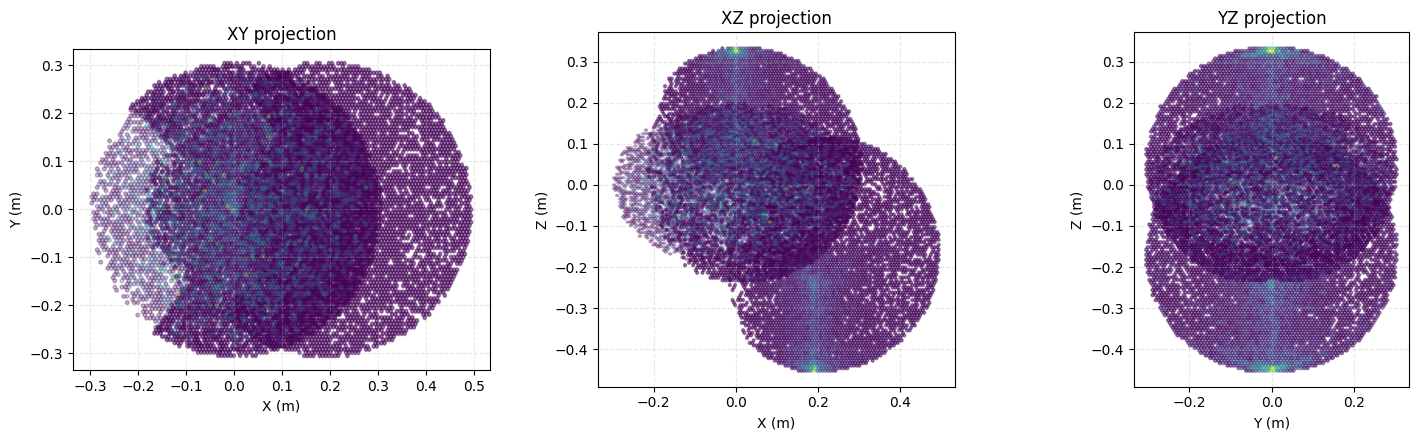

In [8]:
# -------------------- Sampling --------------------
def generate_rov_ellipsoid(a=0.5, b=0.3, c=0.2, num_points=10_000, center=(0,0,0), R=None, rng=None):
    """
    Uniformly sample points inside the ellipsoid (x/a)^2 + (y/b)^2 + (z/c)^2 <= 1.
    Rejection-free using random directions + radius^(1/3).
    - center: optional 3D translation
    - R: optional 3x3 rotation matrix
    """
    rng = np.random.default_rng(rng)
    v = rng.normal(size=(num_points, 3))
    v /= np.linalg.norm(v, axis=1, keepdims=True).clip(min=1e-12)  # unit directions
    r = rng.random((num_points, 1)) ** (1/3)                        # radial distribution
    pts = r * v * np.array([a, b, c])
    if R is not None:
        pts = pts @ np.asarray(R).T
    return pts + np.asarray(center)

# -------------------- Utilities --------------------
def _limits_from_data(arrs, pad=0.05):
    """Get padded min/max per axis from a list of arrays shaped (N, D), D=2 or 3."""
    arrs = [np.asarray(a) for a in arrs if a is not None and len(a) > 0]
    data = np.vstack(arrs)
    mins, maxs = data.min(axis=0), data.max(axis=0)
    span = np.maximum(maxs - mins, 1e-9)
    return mins - pad * span, maxs + pad * span


def plot_workspace_2d(positions_fb, positions_fx, extra_pts=None,
                      s_fb=2, s_fx=2, s_extra=1, lims=None, use_hexbin=True, gridsize=80):
    """
    XY, XZ, YZ projections in a single row with equal aspect and shared limits per view.
    """
    Pfb = np.asarray(positions_fb)
    Pfx = np.asarray(positions_fx)
    Pex = np.asarray(extra_pts) if extra_pts is not None else None

    views = [('X','Y',(0,1)), ('X','Z',(0,2)), ('Y','Z',(1,2))]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

    for ax, (ax0, ax1, (i, j)) in zip(axes, views):
        if lims is None:
            mins2, maxs2 = _limits_from_data([
                Pfb[:, [i, j]],
                Pfx[:, [i, j]],
                (Pex[:, [i, j]] if Pex is not None else None)
            ])
        else:
            mins2 = np.array(lims[0])[ [i, j] ]
            maxs2 = np.array(lims[1])[ [i, j] ]

        if use_hexbin:
            ax.hexbin(Pfb[:, i], Pfb[:, j], gridsize=gridsize, mincnt=1, alpha=0.5)
            ax.hexbin(Pfx[:, i], Pfx[:, j], gridsize=gridsize, mincnt=1, alpha=0.5)
            if Pex is not None:
                ax.hexbin(Pex[:, i], Pex[:, j], gridsize=gridsize, mincnt=1, alpha=0.3)
        else:
            ax.scatter(Pfb[:, i], Pfb[:, j], s=s_fb, alpha=0.5, label='Floating-base manipulator')
            # ax.scatter(Pfx[:, i], Pfx[:, j], s=s_fx, alpha=0.5, label='Fixed-base manipulator')
            if Pex is not None:
                ax.scatter(Pex[:, i], Pex[:, j], s=s_extra, alpha=0.3, label='ROV ellipsoid')

        ax.set_xlabel(f'{ax0} (m)'); ax.set_ylabel(f'{ax1} (m)')
        ax.set_xlim(mins2[0], maxs2[0]); ax.set_ylim(mins2[1], maxs2[1])
        ax.set_aspect('equal', 'box'); ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_title(f'{ax0}{ax1} projection')
        if not use_hexbin:
            ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

floating_base_ellipsoid_clpts = generate_rov_ellipsoid(a=0.3, b=0.3, c=0.2, num_points=10000)
plot_workspace_2d(positions_fb, positions_fx, extra_pts=floating_base_ellipsoid_clpts)

In [9]:
# Precompute convex hull from your workspace points (positions_fb: (N x 3) array)
workspace_hull = ConvexHull(workspace_points)
floating_base_hull = ConvexHull(floating_base_ellipsoid_clpts)

def is_endeffector_point_workspace_valid(point):
    """
    Returns True if 'point' is in the workspace hull but *not* in the vehicle hull.
    Equivalently, we want:  point ∈ (Workspace Vehicle) = Workspace ∩ (Vehicle)^c
    """
    inside_workspace = np.all(
        np.dot(workspace_hull.equations[:, :-1], point) + workspace_hull.equations[:, -1] <= 0
    )
    inside_vehicle = np.all(
        np.dot(floating_base_hull.equations[:, :-1], point) + floating_base_hull.equations[:, -1] <= 0
    )
    # accept the point if it is inside the workspace and *not* inside the vehicle hull.
    return inside_workspace and not inside_vehicle

In [10]:
task_point = np.array([0.31396762,  0.00519786, -0.21436635])  # Example target position

if is_endeffector_point_workspace_valid(task_point):
    print("Task is within the workspace.")
else:
    print("Task is out-of-workspace.")

Task is within the workspace.


In [11]:
def in_hull(points, hull, tol=1e-9):
    """
    Vectorized test: returns a boolean mask of which points are inside `hull`.
    points: (N, d)
    hull.equations: (F, d+1), rows are [normal, offset]
    """
    A = hull.equations[:, :-1]   # normals
    b = hull.equations[:, -1]    # offsets
    # shape: (N, F)
    vals = points @ A.T + b
    return np.all(vals <= tol, axis=1)

# 1. Points that are inside the workspace hull
# (will typically all be True if workspace_points built that hull)
inside_workspace = in_hull(workspace_points, workspace_hull)

# 2. Points that are inside the floating base hull
inside_vehicle = in_hull(workspace_points, floating_base_hull)

# 3. Valid points: inside workspace and not inside vehicle
valid_mask = inside_workspace & (~inside_vehicle)
valid_workspace_points = workspace_points[valid_mask]

print("Total workspace points:", workspace_points.shape[0])
print("Valid points (no collision):", valid_workspace_points.shape[0])

Total workspace points: 15000
Valid points (no collision): 14093


In [12]:
def sample_valid_workspace_points(k, valid_points):
    """
    Randomly sample k points from the prefiltered valid workspace set.
    """
    if len(valid_points) == 0:
        raise ValueError("No valid workspace points available.")
    idx = np.random.choice(len(valid_points), size=k, replace=len(valid_points) < k)
    return valid_points[idx]



In [18]:
q012_fun, q012, p_base = alpha_params.build_analytic_ik_casadi()

# Example
samples = sample_valid_workspace_points(80000, positions_fx)
N = samples.shape[0]
F_q012_fun = q012_fun.map(N)
joint_workspace_samples = F_q012_fun(samples.T).T
fk_eval_vec = fk_eval.map(N)
# q012_fun.save("ik_eval.casadi")

In [21]:
fk_eval_vec(joint_workspace_samples.T, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T[80,:]

DM([[0.174562, 0.149427, -0.0464831, -0.984773, 0.771865, -3.0516]])

In [22]:
samples[80,:]

array([ 0.20947768,  0.1793155 , -0.03717907])